# Homogeneous model optimization using an evolutionary approach

In the previous tutorial, we used a grid search to fit the parameters of a homogeneous rWW model to the empirical data of our example subject.
Here, we will use an evolutionary optimization approach for the same goal.

While grid search systematically samples the entire parameter space (at a predefined resolution), evolutionary optimizers explore the parameter space more selectively. They operate through a series of **generations** (or **iterations**) that iteratively move toward the optimal region. Typically, the optimization starts with a random distribution of **particles** across the parameter space. Each particle represents a set of parameters, for which a simulation is run and a cost is calculated based on the empirical target data. The cost function of the particles in one generation influences the sampling of the next generation, iteratively guiding the search toward regions that minimize the cost.

The cuBNM toolbox supports any optimizer implemented in the `pymoo` Python package ([see the list here](https://pymoo.org/algorithms/list.html)). However, it features the Covariance Matrix Adaptation Evolution Strategy (CMA-ES) as a selected optimization algorithm that has been shown to perform well in fitting brain network models (BNMs) \[[Wischnewski et al. 2022](https://doi.org/10.1038/s41598-022-07860-7)\].

In this tutorial, we will run a CMA-ES optimization to fit the parameters of the same homogeneous rWW model used previously (with three free parameters: $G$, $w^{EE}$, and $w^{EI}$). The optimization will be allowed to run for a maximum of 81 generations with 24 particles (simulations) per generation, resulting in up to 1,944 simulations. However, the optimization can terminate earlier if convergence is achieved before reaching the maximum number of generations.

## Running and saving the CMA-ES optimization

First, we'll load the example structural connectivity (SC) and target empirical BOLD data, which is the same as the data used in the previous tutorials.

In [1]:
from cubnm import datasets

# load structural connectome
sc = datasets.load_sc('strength', 'schaefer-100')
# load empirical bold signal
emp_bold = datasets.load_bold('schaefer-100')

Next, we define the simulation options, similar to those used in the previous tutorials. To reduce the clutter in the printed output, here we set `sim_verbose` to `False`.

In [2]:
sim_options = dict(
    duration=435,
    bold_remove_s=15,
    TR=0.6,
    sc=sc,
    sc_dist=None,
    dt='0.1',
    bw_dt='1.0',
    ext_out=True,
    states_ts=True,
    states_sampling=0.1,
    noise_out=False,
    rand_seed=421,
    noise_segment_length=30,
    gof_terms=['+fc_corr', '-fcd_ks'],
    do_fc=True,
    do_fcd=True,
    window_size=30,
    window_step=5,
    fcd_drop_edges=True,
    exc_interhemispheric=False,
    bw_params='heinzle2016-3T',
    sim_verbose=True,
    do_fic=True,
    max_fic_trials=0
)

# disable simulation verbosity
sim_options['sim_verbose'] = False

We now define the optimization problem using `BNMProblem`, just as we did for the grid search.

In [3]:
from cubnm import optimize

problem = optimize.BNMProblem(
    model = 'rWW',
    params = {
        'G': (0.5, 10.0), 
        'wEE': (0.01, 2.1), # to 10x of Deco 2014 (w+ = 1.4 * J_NMDA = 0.15 => 0.21)
        'wEI': (0.01, 1.5) # to 10x of Deco 2014 (J_NMDA = 0.15)
    },
    emp_bold = emp_bold,
    out_dir = './cmaes_homo',
    **sim_options
)

Here we specified the model (`model`), the free parameters to explore along with their ranges (`params`), the empirical BOLD data we want to fit the simulations to (`emp_bold`), and the simulation options defined above (`**sim_options`).

We now create a CMA-ES optimizer (`CMAESOptimizer`) object and define its properties.

In [4]:
cmaes = optimize.CMAESOptimizer(    
    popsize=24,
    n_iter=81, 
    seed=1,
    algorithm_kws=dict(tolfun=5e-3)
)

We plan to run a maximum of `n_iter=81` iterations, with a population size of `popsize=24` simulations/particles per iteration.

Since the sampling is stochastic, we set a random `seed=1` to ensure reproducibility. In practice, it is recommended to repeat CMA-ES runs with different seeds to avoid convergence to local optima.

The `algorithm_kws` argument specifies additional settings for the optimizer. Here, `tolfun=5e-3` defines the tolerance for early stopping. If the cost function does not improve by more than 0.005 across recent generations or across the particles of the last generation, the optimization will terminate early. (For more details, see [Hansen et al. 2016](https://arxiv.org/pdf/1604.00772)).

Next, we assign the optimization `problem` to the CMA-ES optimizer `cmaes` using the `setup_problem()` method:

In [5]:
cmaes.setup_problem(problem)

Then, run the optimization and save its results (Note that this will take a while):

In [6]:
%%time
# run the optimization
cmaes.optimize()

# save the results
cmaes.save()

Initializing GPU session...
took 2.527310 s
Running 24 simulations...
took 15.002406 s
           G       wEE       wEI      cost  +fc_corr   -fcd_ks      +gof  -fic_penalty  gen
0   3.779903  0.503752  1.461171  0.613951  0.259293 -0.873244 -0.613951      0.000000    1
1   8.314490  0.911225  0.607791  1.510341  0.276481 -0.725972 -0.449491     -1.060850    1
2   6.320800  0.714351  0.386070  2.554230  0.189416 -0.879241 -0.689825     -1.864405    1
3   6.986303  1.558823  0.945011  0.751796  0.276264 -0.805532 -0.529268     -0.222528    1
4   9.307112  0.031676  1.424772  0.559625  0.275079 -0.810143 -0.535064     -0.024561    1
5   1.754730  1.730758  0.157037  2.852513  0.028308 -0.880831 -0.852523     -1.999989    1
6   4.968666  0.380767  0.917021  0.561410  0.277640 -0.836276 -0.558636     -0.002774    1
7   1.386736  0.628036  0.656448  0.639983  0.236681 -0.876664 -0.639983      0.000000    1
8   7.985046  1.217935  1.307215  0.615680  0.274325 -0.832215 -0.557891     -0.05778

'./cmaes_homo/cmaes_run-0'

We can see that the optimizer converged after 49 iterations and stopped earlier than the specified maximum 81 iterations. 

<div class="alert alert-info">
<p>
Note: At the end of the CMA-ES optimization (if convergence is reached), the algorithm samples a single final particle in the last generation, which represents its best estimate of the optimal point. However, the actual optimal simulation (`cmaes.opt`) is defined as the particle with the lowest cost across the entire optimization history (`cmaes.history`). As a result, the best estimate from the final generation and the true optimum found during the search may differ.
</p>
</div>


When `cmaes.save()` is called, the optimal simulation is re-run so that its simulated data can be saved to disk. Similar to the grid search, the simulated data, parameters and cost function components of the optimal simulation, as well as the optimizer history, simulation and optimization configurations (including SC and target FC/FCD) are saved to disk. For a detailed description of the saved files, see the [grid search tutorial](grid_search.ipynb).

## Visualization of the optimization history

The parameters of all simulations (particles) run during the optimization, along with their associated cost function and its components, are stored in `cmaes.history`.

In [7]:
cmaes.history

,index,G,wEE,wEI,cost,+fc_corr,-fcd_ks,+gof,-fic_penalty,gen
0,0,3.779903,0.503752,1.461171,0.613951,0.259293,-0.873244,-0.613951,0.000000,1
1,1,8.314490,0.911225,0.607791,1.510341,0.276481,-0.725972,-0.449491,-1.060850,1
2,2,6.320800,0.714351,0.386070,2.554230,0.189416,-0.879241,-0.689825,-1.864405,1
3,3,6.986303,1.558823,0.945011,0.751796,0.276264,-0.805532,-0.529268,-0.222528,1
4,4,9.307112,0.031676,1.424772,0.559625,0.275079,-0.810143,-0.535064,-0.024561,1
...,...,...,...,...,...,...,...,...,...,...
1172,20,1.832297,0.011249,0.133643,0.068598,0.210262,-0.118814,0.091448,-0.160046,49
1173,21,1.839730,0.010839,0.134318,0.068186,0.210186,-0.117441,0.092745,-0.160931,49
1174,22,1.786765,0.011715,0.127392,0.069084,0.209652,-0.119850,0.089802,-0.158886,49
1175,23,1.853451,0.011140,0.136714,0.069818,0.210766,-0.121263,0.089503,-0.159321,49


We can visualize how negative cost evolved over the course of CMA-ES optimization. Here, to indicate better simulations with higher values, rather than the cost function we will visualize negative cost function.

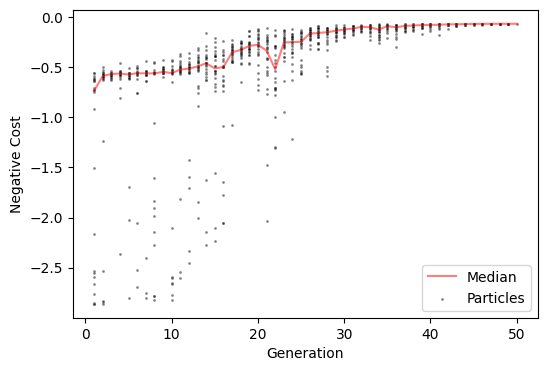

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# calculate negative cost
hist = cmaes.history.copy()
hist['-cost'] = -hist['cost']
# calculate its median in each generation
hist_median = hist.groupby("gen")["-cost"].median()
# plot
fig, ax = plt.subplots(figsize=(6, 4))
# median
ax.plot(hist_median, color="red", alpha=0.5, label='Median')
# individual particles
sns.scatterplot(data=hist, x='gen', y='-cost', s=4, alpha=0.5, color='black', ax=ax, label='Particles')
# aesthetics
ax.set_ylabel('Negative Cost')
ax.set_xlabel('Generation')
ax.legend()

We can also visualize how the particles moved through the 3D parameter space (`'G'`, `'wEE'`, `'wEI'`) across generations. We will create a GIF showing the progression of particles over time.

In [9]:
import imageio
import os
import tempfile

free_params = ['G', 'wEE', 'wEI']
frames = []
temp_dir = tempfile.mkdtemp()

# using consistent color ranges and axes across frames
vmin = hist['-cost'].min()
vmax = hist['-cost'].max()
xlim = (hist['G'].min(), hist['G'].max())
ylim = (hist['wEE'].min(), hist['wEE'].max())
zlim = (hist['wEI'].min(), hist['wEI'].max())


# loop through each generation and save a frame
for gen in range(hist['gen'].min(), hist['gen'].max() + 1):
    fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': '3d'})
    plot_df = hist.set_index(free_params).reset_index()
    plot_df = plot_df[plot_df['gen'] == gen]
    scatter = ax.scatter(
        plot_df.loc[:, free_params[0]],
        plot_df.loc[:, free_params[1]],
        plot_df.loc[:, free_params[2]],
        c=plot_df.loc[:, '-cost'],
        alpha=0.6,
        s=20,
        cmap='viridis',
        vmin=vmin, vmax=vmax
    )
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    ax.set_title(f'Generation {gen}')
    ax.set_xlabel(free_params[0])
    ax.set_ylabel(free_params[1])
    ax.set_zlabel(free_params[2])
    ax.view_init(elev=15, azim=-15)
    ax.set_box_aspect(None, zoom=0.85)
    fig.tight_layout()
    # save frame
    frame_path = os.path.join(temp_dir, f'frame_{gen}.png')
    plt.savefig(frame_path)
    frames.append(frame_path)
    plt.close(fig)

# create the GIF
images = [imageio.imread(frame) for frame in frames]
imageio.mimsave('./cmaes_3d.gif', images, fps=2, loop=0)

/tmp/ipykernel_47174/387647226.py:49: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(frame) for frame in frames]


![CMAES GIF](./cmaes_3d.gif)

This visualization shows how over successive generations the particles are gradually concentrated into a specific region of the parameter space.

## Visualization of the optimal simulation

Lastly, we will visualize the simulated FC and FCD of the optimal simulation and compare them to the empirical data.

First, we calculate the empirical FC and FCD from the empirical BOLD signal using utility functions from `cubnm.utils`:

In [10]:
from cubnm import utils

# calculate empirical FC
emp_fc = utils.calculate_fc(emp_bold, return_tril=False)
# calculate empirical FCD using the same window size
# and step used in the simulations
emp_fcd = utils.calculate_fcd(
    emp_bold,
    window_size=cmaes.problem.sim_group.window_size_TRs, 
    window_step=cmaes.problem.sim_group.window_step_TRs, 
    return_tril=False
)

We can then plot the empirical FC next to the simulated FC. Note that at the end of the single-objective optimizations such as CMA-ES, `cmaes.problem.sim_group` contains a single simulation which is the optimum, therefore we can access its data by providing `0` as the simulation index.

Text(0.5, 1.0, 'Simulated FC')

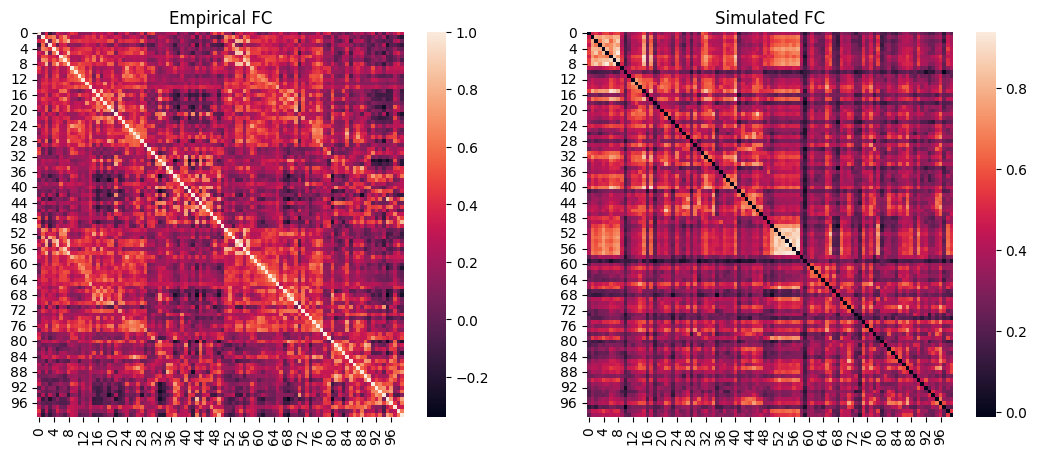

In [11]:
import numpy as np
import seaborn as sns

sim_idx = 0

# construct full FC from the lower triangle which is stored in sim_group
sim_fc = np.zeros((cmaes.problem.sim_group.nodes, cmaes.problem.sim_group.nodes))
sim_fc[np.tril_indices_from(sim_fc, -1)] = cmaes.problem.sim_group.sim_fc_trils[sim_idx]
sim_fc += sim_fc.T

# plot it next to the empirical FC
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(emp_fc, ax=axes[0])
axes[0].set_title("Empirical FC")
sns.heatmap(sim_fc, ax=axes[1])
axes[1].set_title("Simulated FC")

Text(0, 0.5, 'Empirical FC')

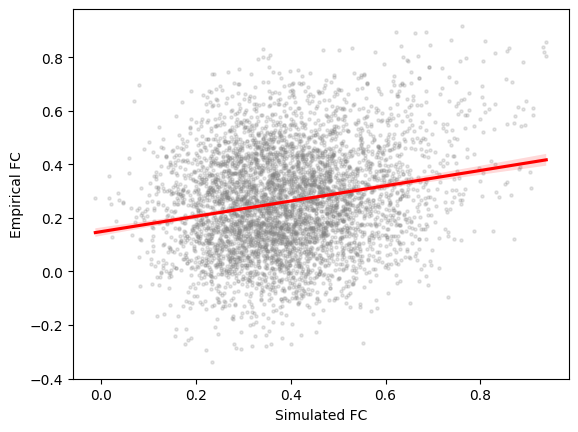

In [12]:
# regression plot
fig, ax = plt.subplots()
sns.regplot(
    x=sim_fc[np.tril_indices(100, -1)],
    y=emp_fc[np.tril_indices(100, -1)],
    scatter_kws=dict(s=5, alpha=0.2, color="grey"),
    line_kws=dict(color="red"),
)
ax.set_xlabel("Simulated FC")
ax.set_ylabel("Empirical FC")

In addition to static FC, we can also plot the simulated FCD matrix and its distribution. Since only the lower triangle of the FCD is stored in `cmaes.problem.sim_group.sim_fcd_trils`, reconstructing the full matrix would require knowing the number of windows. However, it is simpler to directly recalculate the FCD from the simulated BOLD signal using `cubnm.utils.calculate_fcd`:

Text(0.5, 1.0, 'Simulated FC')

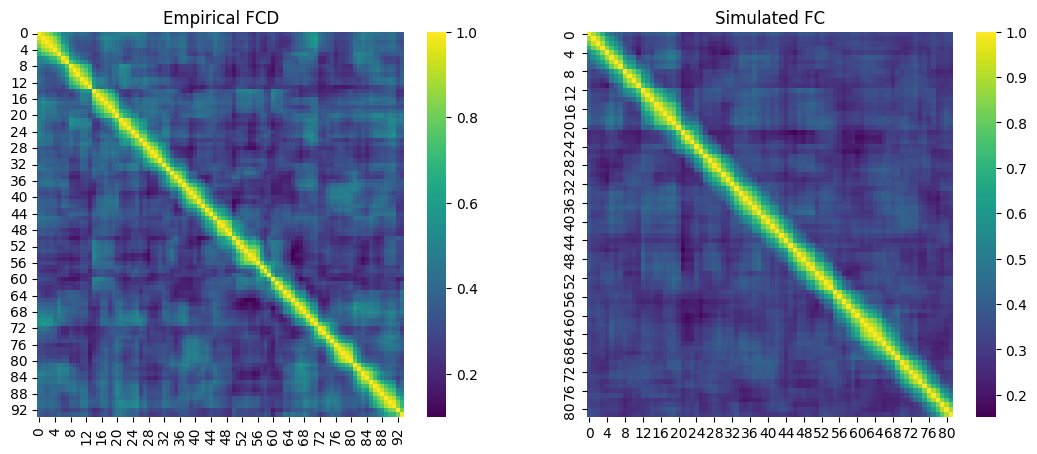

In [13]:
# calculate number of initial BOLD volumes to remove
bold_remove_vols = int(cmaes.problem.sim_group.bold_remove_s // cmaes.problem.sim_group.TR)
# recalculate simulated FCD based on BOLD
sim_fcd = utils.calculate_fcd(
    cmaes.problem.sim_group.sim_bold[sim_idx, bold_remove_vols:, :].T.copy(), 
    window_size=cmaes.problem.sim_group.window_size_TRs, 
    window_step=cmaes.problem.sim_group.window_step_TRs, 
    return_tril=False
)

# double check that its lower triangle is equal to the FCD lower triangle calculated
# on GPU via .run()
assert np.isclose(cmaes.problem.sim_group.sim_fcd_trils[sim_idx], sim_fcd[np.tril_indices_from(sim_fcd, -1)]).all()

# plot it next to the empirical FCD
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(emp_fcd, ax=axes[0], cmap='viridis')
axes[0].set_title("Empirical FCD")
sns.heatmap(sim_fcd, ax=axes[1], cmap='viridis')
axes[1].set_title("Simulated FC")

We can also compare the distributions of FCD (lower triangle) values between the empirical and simulated data:

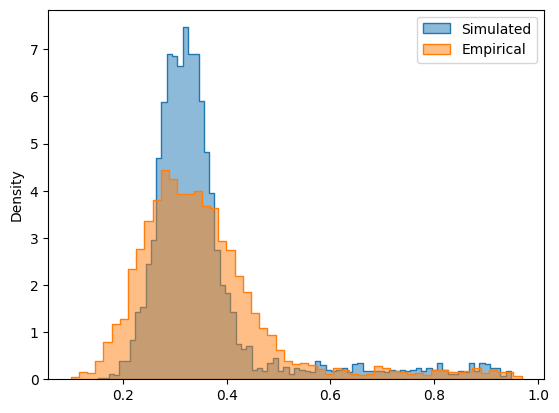

In [14]:
# histograms
sns.histplot(cmaes.problem.sim_group.sim_fcd_trils[sim_idx], element='step', alpha=0.5, label='Simulated', stat='density')
ax = sns.histplot(emp_fcd[np.tril_indices_from(emp_fcd, -1)], element='step', alpha=0.5, label='Empirical', stat='density')
ax.legend()

The simulated and empirical FC and FCD are quantitatively compared using the FC correlation (`+fc_corr`) and FCD KS distance (`-fcd_ks`). These metrics, along with the other cost function components and the parameters of the optimal simulation, are stored in `cmaes.opt`:

In [15]:
cmaes.opt

index            8.000000
G                1.846711
wEE              0.010570
wEI              0.135123
cost             0.067975
+fc_corr         0.210271
-fcd_ks         -0.117348
+gof             0.092923
-fic_penalty    -0.160897
gen             49.000000
Name: 1160, dtype: float64

We can observe that this optimal simualtion has a considerably lower cost and higher goodness-of-fit compared to the optimal point found in the [grid search tutorial](grid_search.ipynb), which had a cost of 0.223 and goodness-of-fit of -0.039. This shows the power of evolutionary optimization algorithms over brute-force grid search.
One advantage is that evolutionary optimizers are not limited by a fixed sampling resolution, and rather, they can explore parameter values more flexibly and precisely, allowing them to reach better optima.